# Plotting radials, quality control flags, and total vectors

In [1]:
from hfradarpy.radials import Radial, qc_radial_file
import glob
import os
import xarray as xr

In [2]:
# Path to radial directory
radial_dir = '/Users/mikesmith/Documents/github/rucool/hfradarpy/hfradarpy/data/radials/ruv/SEAB/'
save_dir = '/Users/mikesmith/Documents/github/rucool/hfradarpy/hfradarpy/data/radials_qc/ruv/SEAB/'

# Use glob to find radial files (*
files = sorted(glob.glob(os.path.join(radial_dir, '*.ruv')))

# Load one radial file for this notebook

In [3]:
r = Radial(files[1])
r

<Radial: RDLi_SEAB_2019_01_01_0300.ruv>

In [34]:
r.metadata

OrderedDict([('CTF', '1.00'),
             ('FileType', 'LLUV rdls "RadialMap"'),
             ('LLUVSpec', '1.27  2017 01 13'),
             ('UUID', 'F057FF72-B573-4FD5-9CDE-5D4FA0275FA4'),
             ('Manufacturer', 'CODAR Ocean Sensors. SeaSonde'),
             ('Site', 'SEAB ""'),
             ('TimeStamp', '2019 01 01  03 00 00'),
             ('TimeZone', '"UTC" +0.000 0 "Atlantic/Reykjavik"'),
             ('TimeCoverage', '75.000 Minutes'),
             ('Origin', '40.3668167  -73.9735333'),
             ('GreatCircle', '"WGS84" 6378137.000  298.257223562997'),
             ('GeodVersion', '"CGEO" 1.85  2017 10 05'),
             ('LLUVTrustData', 'all  all lluv xyuv rbvd'),
             ('RangeStart', '2'),
             ('RangeEnd', '22'),
             ('RangeResolutionKMeters', '3.020300'),
             ('RangeCells', '31'),
             ('DopplerCells', '512'),
             ('DopplerInterpolation', '2'),
             ('AntennaBearing', '151.0 True'),
             ('Refer

# Define QARTOD quality control flags in a dictionary and run each quality control test

In [4]:
# run high frequency radar qartod tests on open radial file

qc_values = dict(
    qc_qartod_avg_radial_bearing=dict(reference_bearing=151, warning_threshold=15, failure_threshold=30),
    qc_qartod_radial_count=dict(radial_min_count=75.0, radial_low_count=225.0),
    qc_qartod_maximum_velocity=dict(radial_max_speed=300.0, radial_high_speed=100.0),
    qc_qartod_spatial_median=dict(radial_smed_range_cell_limit=2.1, radial_smed_angular_limit=10, radial_smed_current_difference=30),
    qc_qartod_temporal_gradient=dict(gradient_temp_fail=32, gradient_temp_warn=25),
    qc_qartod_primary_flag=dict(include=['qc_qartod_syntax', 'qc_qartod_valid_location', 'qc_qartod_radial_count',
                                         'qc_qartod_maximum_velocity', 'qc_qartod_spatial_median'])
)
r.initialize_qc()
r.qc_qartod_syntax()
r.qc_qartod_maximum_velocity(**qc_values['qc_qartod_maximum_velocity'])
r.qc_qartod_valid_location()
r.qc_qartod_radial_count(**qc_values['qc_qartod_radial_count'])
r.qc_qartod_spatial_median(**qc_values['qc_qartod_spatial_median'])
r.qc_qartod_temporal_gradient(files[1]) #pass the previous hourly radial to this one
r.qc_qartod_avg_radial_bearing(**qc_values['qc_qartod_avg_radial_bearing'])
r.qc_qartod_primary_flag(**qc_values['qc_qartod_primary_flag'])

/Users/mikesmith/miniconda3/envs/hfradarpy/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1218: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


In [5]:
r.data

,LOND,LATD,VELU,VELV,VFLG,...,QC09,QC10,QC11,QC12,PRIM
0,-73.972291,40.421208,0.149,8.557,128,...,1,1,1,1,4
1,-73.966093,40.420918,-0.586,-5.570,128,...,1,1,1,1,4
2,-73.959952,40.420215,-0.446,-2.290,128,...,1,1,1,1,4
3,-73.953915,40.419107,-2.146,-7.477,128,...,1,1,1,1,4
4,-73.948027,40.417600,-2.009,-5.228,128,...,1,1,1,1,4
...,...,...,...,...,...,...,...,...,...,...,...
707,-73.196236,40.301654,-16.077,1.833,0,...,1,1,1,1,1
708,-73.206897,40.250093,-17.992,3.659,0,...,1,1,1,1,1
709,-73.223362,40.199438,-12.383,3.665,0,...,1,1,1,1,1
710,-73.245494,40.150072,-16.072,6.322,0,...,1,1,1,1,1


# Import plotting packages.
For this notebook, we will use matplotlib and cartopy

In [6]:
# Import matplotlib and cartopy
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

In [7]:
# Adjust some standard plotting settings to make them the size of a sheet of paper
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 12
fig_size[1] = 8
plt.rcParams["figure.figsize"] = fig_size

# Set colors of the land. 
edgecolor = 'black'
landcolor = 'tan'

LAND = cfeature.NaturalEarthFeature(
    'physical', 'land', '10m',
    edgecolor='face',
    facecolor='tan'
)

state_lines = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='50m',
    facecolor='none'
)

# Define the extent (x and y limits) of the plot 

In [8]:
extent = [r.data.LOND.min(), r.data.LOND.max(), 39.75, 41]

In [9]:
# Create a re-usable function for map features that we can pass an axes to.
def map_features(ax):
    # Axes properties and features
    ax.set_extent(extent)
    ax.add_feature(LAND, edgecolor=edgecolor, facecolor=landcolor)
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.RIVERS)
    ax.add_feature(cfeature.LAKES)
    ax.add_feature(cfeature.BORDERS)
    ax.add_feature(state_lines, zorder=11, edgecolor=edgecolor)

    # Gridlines and grid labels
    gl = ax.gridlines(
        draw_labels=True,
        linewidth=.5,
        color='black',
        alpha=0.25,
        linestyle='--'
    )

    gl.top_labels = gl.right_labels = False
    gl.xlabel_style = {'size': 10, 'color': 'black'}
    gl.ylabel_style = {'size': 10, 'color': 'black'}
    gl.xlocator = mticker.MaxNLocator(integer=True)
    gl.ylocator = mticker.MaxNLocator(integer=True)
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER

    ax.tick_params(which='major',
                   direction='out',
                   bottom=True, top=True,
                   labelbottom=True, labeltop=False,
                   left=True, right=True,
                   labelleft=True, labelright=False,
                   length=5, width=2)

    ax.tick_params(which='minor',
                   direction='out',
                   bottom=True, top=True,
                   labelbottom=True, labeltop=False,
                   left=True, right=True,
                   labelleft=True, labelright=False,
                   width=1)

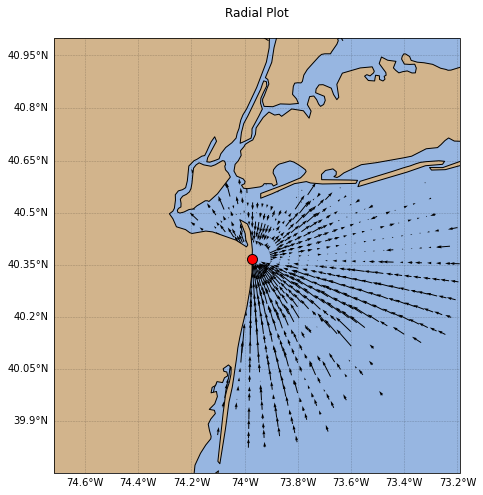

In [10]:
# Intialize an empty subplot using cartopy
fig, ax = plt.subplots(
    figsize=(11, 8),
    subplot_kw=dict(projection=ccrs.Mercator())
)

plt.title(f'Radial Plot\n')
# plt.quiver(tds.lon.data, tds.lat.data, tds.u.data, tds.v.data, transform=ccrs.PlateCarree())
plt.quiver(r.data.LOND, r.data.LATD, r.data.VELU, r.data.VELV, transform=ccrs.PlateCarree())


# Get the receiver location for plotting purposes
receiver_location = [float(x) for x in r.metadata['Origin'].split('  ')]
receiver_location.reverse()
receiver_location

plt.plot(receiver_location[0], receiver_location[1], 'o', markersize=10, markeredgecolor='black', color='red', transform=ccrs.PlateCarree())

map_features(ax)


In [11]:
# Split out everything into seperate variables in order to pass them easier to the plotting functions
time = r.time
lon = r.data.LOND
lat = r.data.LATD
u = r.data.VELU
v = r.data.VELV
velocity = r.data.VELO

# Mask nans just in case there are any
import numpy.ma as ma

u = ma.masked_invalid(u)
v = ma.masked_invalid(v)

# Normalize vectors to one size

In [12]:
from oceans.ocfis import uv2spdir, spdir2uv

# convert U and V component velocities to angle and speed
angle, speed = uv2spdir(u, v) 

# convert angle and speed right back back to U and V component velocities,
# Passing speed as an array of 1's allows for the normalizing of the arrow sizes
# if we pass the correct 
u, v = spdir2uv( 
    np.ones_like(speed),
    angle,
    deg=True
)

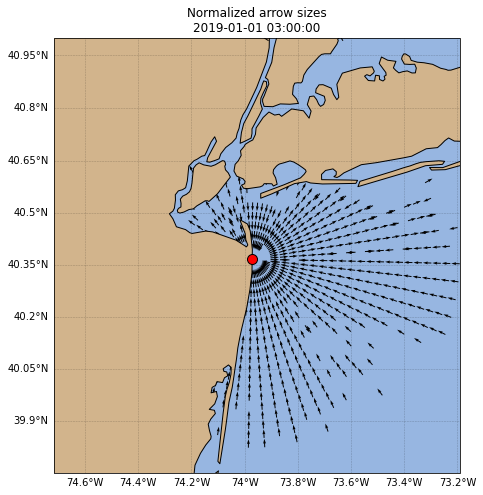

In [14]:
# Intialize an empty subplot using cartopy
fig, ax = plt.subplots(
    figsize=(11, 8),
    subplot_kw=dict(projection=ccrs.Mercator())
)

plt.title(f'Normalized arrow sizes\n{time}')
plt.quiver(lon, lat, u, v, transform=ccrs.PlateCarree())
plt.plot(receiver_location[0], receiver_location[1], 'o', markersize=10, markeredgecolor='black', color='red', transform=ccrs.PlateCarree())

map_features(ax)

# Make a radial plot of the arrows with colors that display speed

In [15]:
import cmocean

"""
Displays the direction and magnitude of the radials
"""
cmap = cmocean.cm.balance

# The next lines specify the arrow shapes. You can customize this to your preference, usually by trial and error.
scale=50
headwidth=2.5
headlength=4
headaxislength=4
sub=1

# Colorbar options
velocity_min = -40 # The minimum speed that should be displayed on the colorbar
velocity_max = 40 # The maximum speed that should be displayed on the colorbar
cbar_step = 10 # The step between each colorbar tick

In [16]:
# Define arrow colors. Limited by velocity_min and velocity_max
color_clipped = np.clip(
    r.data.VELO[::sub],
    velocity_min,
    velocity_max
).squeeze()

ticks = np.append(np.arange(velocity_min, velocity_max, cbar_step), velocity_max)

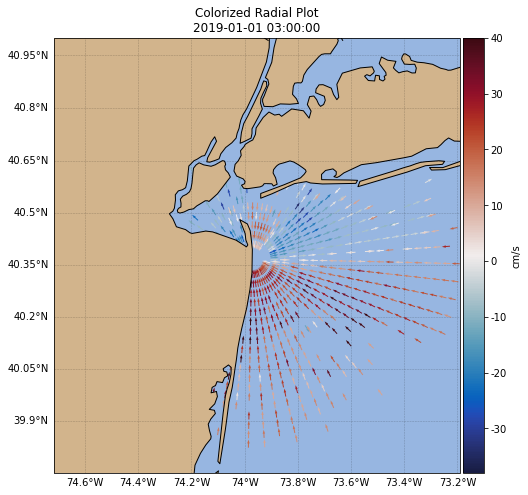

In [17]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(
        figsize=(11, 8),
        subplot_kw=dict(projection=ccrs.Mercator())
    )

# Plot title
plt.title(f'Colorized Radial Plot\n{time}')

qargs = dict(cmap=cmap, scale=scale, headwidth=headwidth, headlength=headlength, headaxislength=headaxislength)
qargs['transform'] = ccrs.PlateCarree()
# qargs['norm'] = offset

# plot arrows over pcolor
h = ax.quiver(
    lon[::sub],
    lat[::sub],
    u[::sub],
    v[::sub],
    color_clipped,
    **qargs
)
map_features(ax)

# generate colorbar
divider = make_axes_locatable(ax)
cax = divider.new_horizontal(size='5%', pad=0.05, axes_class=plt.Axes)
fig.add_axes(cax)

cb = plt.colorbar(h, cax=cax, ticks=ticks)
cb.ax.set_yticklabels([f'{s:d}' for s in ticks])
cb.set_label('cm/s')

# We can use colormap normalization functions to adjust our colormaps
-40 is missing from the colorbar so I'm going to manually normalize the colorbar using the minimum and maximum velocity from the data

In [18]:
# Linearly normalizes velocity data into the [velocity_min, velocity_max] interval.
from matplotlib.colors import Normalize

offset = Normalize(vmin=velocity_min, vmax=velocity_max, clip=True)

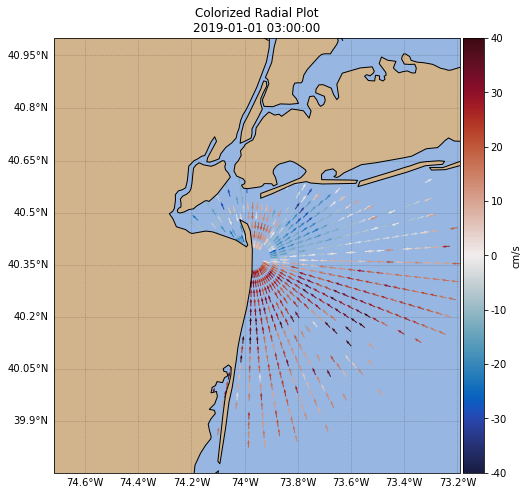

In [19]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(
        figsize=(11, 8),
        subplot_kw=dict(projection=ccrs.Mercator())
    )

# Plot title
plt.title(f'Colorized Radial Plot\n{time}')

qargs = dict(cmap=cmap, scale=scale, headwidth=headwidth, headlength=headlength, headaxislength=headaxislength)
qargs['transform'] = ccrs.PlateCarree()
qargs['norm'] = offset

# plot arrows over pcolor
h = ax.quiver(
    lon[::sub],
    lat[::sub],
    u[::sub],
    v[::sub],
    color_clipped,
    **qargs
)
map_features(ax)

# generate colorbar
divider = make_axes_locatable(ax)
cax = divider.new_horizontal(size='5%', pad=0.05, axes_class=plt.Axes)
fig.add_axes(cax)

cb = plt.colorbar(h, cax=cax, ticks=ticks)
cb.ax.set_yticklabels([f'{s:d}' for s in ticks])
cb.set_label('cm/s')

# Next up, we are going to make a plot that colors the arrows by whether or not they are going towards (red) or away (blue) from the radar

For these plots, we aren't looking at speed, rather just the direction of the flow of the water.

In [20]:
from matplotlib import colors

"""
Motion displays the direction (towards or away) from radar
"""
title = 'Radial Map: Towards/Away from radar'
cmap= 'bwr'

# We will create temporary variable of velocities that sets any velocity greater than 0 to -1
velocity_temp = velocity.where(velocity > 0, other=-1)  # Going away from radar


# We will create temporary variable of velocities that sets any velocity less than 0 to 1
color_clipped = velocity_temp.where(velocity < 0, other=1)  # Going towards radar

# TwoSlopeNorm function
We can use the TwoSlopeNorm function built into matplotlib.colors to create a linear colormap around a center point.

In [21]:
# For radial directional plots, we will center the colorbar on 0 and set the minimum to -1 and maximum to 1.

# Normalize data with a set center.
from matplotlib.colors import TwoSlopeNorm

offset = TwoSlopeNorm(vmin=-1, vcenter=0, vmax=1)

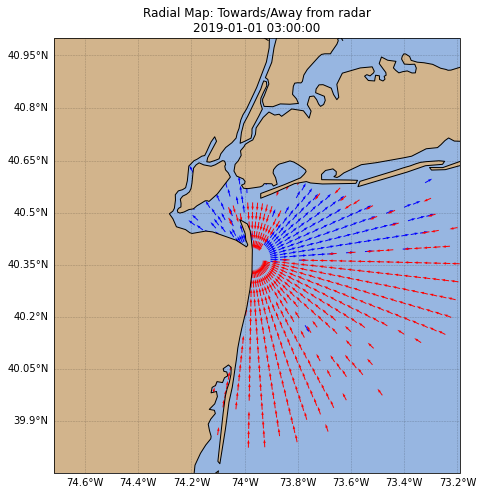

In [22]:
fig, ax = plt.subplots(
        figsize=(11, 8),
        subplot_kw=dict(projection=ccrs.Mercator())
    )

# Plot title
plt.title(f'{title}\n{time}')

qargs = dict(cmap=cmap, scale=scale, headwidth=headwidth, headlength=headlength, headaxislength=headaxislength)
qargs['transform'] = ccrs.PlateCarree()
qargs['norm'] = offset

# plot arrows over pcolor
h = ax.quiver(
    lon[::sub],
    lat[::sub],
    u[::sub],
    v[::sub],
    color_clipped,
    **qargs
)
map_features(ax)


In [23]:
# color_clipped = tds.primary_flag_qc.where(tds.primary_flag_qc == 1, other=-1).data  # PRIM == 1 where vectors pass qc
prim = r.data.PRIM
color_clipped = prim.where(prim == 1, other=-1)


offset = TwoSlopeNorm(vmin=-1, vcenter=0, vmax=1)
title = "Radial Map: QC Pass/Fail"
cmap = colors.ListedColormap(['red', 'limegreen'])

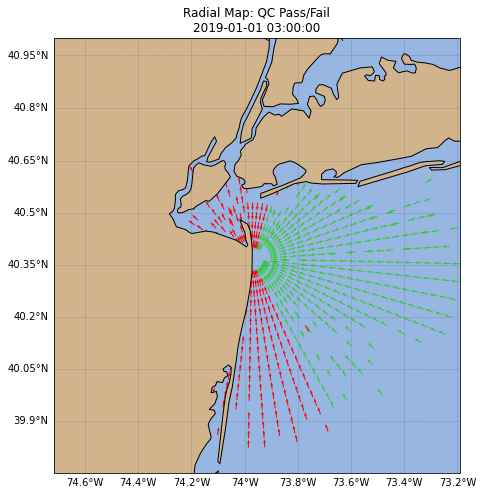

In [25]:
fig, ax = plt.subplots(
        figsize=(11, 8),
        subplot_kw=dict(projection=ccrs.Mercator())
    )

# Plot title
plt.title(f'{title}\n{time}')


qargs = dict(cmap=cmap, scale=scale, headwidth=headwidth, headlength=headlength, headaxislength=headaxislength)
qargs['transform'] = ccrs.PlateCarree()
qargs['norm'] = offset

# plot arrows over pcolor
h = ax.quiver(
    lon[::sub],
    lat[::sub],
    u[::sub],
    v[::sub],
    color_clipped,
    **qargs
)
map_features(ax)
# plt.colorbar(h)


# Plot the totals

In [26]:
file = '/Users/mikesmith/Downloads/realtime_maracoos_6km_totals_qartod_0b87_0831_aef4.nc'

ds = xr.open_dataset(file)
ds

<xarray.Dataset>
Dimensions:              (time: 166, depth: 1, latitude: 187, longitude: 196)
Coordinates:
  * time                 (time) datetime64[ns] 2022-02-21 ... 2022-02-27T21:0...
  * depth                (depth) float32 0.0
  * latitude             (latitude) float32 33.82 33.87 33.93 ... 43.8 43.85
  * longitude            (longitude) float32 -77.91 -77.85 ... -66.64 -66.58
Data variables: (12/13)
    u                    (time, depth, latitude, longitude) float32 ...
    v                    (time, depth, latitude, longitude) float32 ...
    u_err                (time, depth, latitude, longitude) float32 ...
    v_err                (time, depth, latitude, longitude) float32 ...
    total_errors         (time, depth, latitude, longitude) float32 ...
    uv_covariance        (time, depth, latitude, longitude) float32 ...
    ...                   ...
    qc303_maxspeed       (time, depth, latitude, longitude) float32 ...
    qc305_validlocation  (time, depth, latitude, longitude) float32 ...
    qc306_uerr           (time, depth, latitude, longitude) float32 ...
    qc307_verr           (time, depth, latitude, longitude) float32 ...
    qc_primary_flag      (time, depth, latitude, longitude) float32 ...
    qc_operator_flag     (time, depth, latitude, longitude) float32 ...
Attributes: (12/58)
    acknowledgement:               This data is provided by the Mid-Atlantic ...
    cdm_data_type:                 Grid
    comment:                       Network maintained by MARACOOS. For oi_* g...
    contributor_name:              Scott Glenn, Josh Kohut, Hugh Roarty, Etha...
    contributor_role:              Principal Investigator, Principal Investig...
    Conventions:                   CF-1.6, ACDD-1.3, COARDS
    ...                            ...
    summary:                       Optimally Interpolated Total Vectors calcu...
    testOutOfDate:                 now-1day
    time_coverage_end:             2022-02-27T21:00:00Z
    time_coverage_start:           2022-02-21T00:00:00Z
    title:                         Surface Currents - MARACOOS - 5MHz - Realt...
    Westernmost_Easting:           -77.90598

In [27]:
ds = ds.mean('time')
ds

lon = ds.longitude.data
lat = ds.latitude.data
u = ds.u.data
v = ds.v.data
lon.shape, lat.shape, u.shape, v.shape

((196,), (187,), (1, 187, 196), (1, 187, 196))

In [28]:
lons, lats = np.meshgrid(lon, lat)
lons.shape, lats.shape, u.shape, v.shape

((187, 196), (187, 196), (1, 187, 196), (1, 187, 196))

In [29]:
from oceans.ocfis import uv2spdir, spdir2uv

angle, speed = uv2spdir(u.squeeze(), v.squeeze())  # convert u/v to angle and speed
u, v = spdir2uv(  # convert angle and speed back to u/v, normalizing the arrow sizes
    np.ones_like(speed),
    angle,
    deg=True
)

In [30]:
np.nanmin(speed), np.nanmax(speed)

(0.0003244059, 1.5920553)

In [31]:
extent = [-76.2, -69, 33.5, 42]

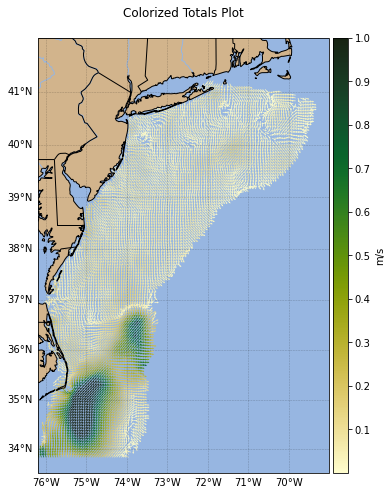

In [33]:
import cmocean

qwargs = dict(
    cmap=cmocean.cm.speed,
    transform=ccrs.PlateCarree(),
    scale=65, # Number of data units per arrow length unit, e.g., m/s per plot width; a smaller scale parameter makes the arrow longer. Default is None.
    headwidth=2.75, # Head width as multiple of shaft width.
    headlength=2.75, #Head length as multiple of shaft width.
    headaxislength=2.5, # Head length at shaft intersection.
    minshaft=1,
    minlength=1
)

# Clip the colors 
color_clipped = np.clip(speed, 0, 1).squeeze()

# Set the colorbar ticks to correspond to the velocity minimum and maximum of the data with a step of 20... Append the max velocity 
ticks = np.append(np.arange(0, 1, .1), 1)

fig, ax = plt.subplots(
        figsize=(11, 8),
        subplot_kw=dict(projection=ccrs.Mercator())
    )

# Plot title
plt.title(f'Colorized Totals Plot\n')

# plot arrows over pcolor
h = ax.quiver(
    lons,
    lats,
    u,
    v,
    color_clipped,
    **qwargs
)
map_features(ax)
ax.set_extent(extent)

# generate colorbar
divider = make_axes_locatable(ax)
cax = divider.new_horizontal(size='5%', pad=0.05, axes_class=plt.Axes)
fig.add_axes(cax)

cb = plt.colorbar(h, cax=cax, ticks=ticks)
# cb.ax.set_yticklabels([f'{s:d}' for s in ticks])
cb.set_label('m/s')